In [1]:
# import the necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import config
from utils import imshow, show_plot, ContrastiveLoss
import torchvision
from torch.autograd import Variable
from PIL import Image
import PIL.ImageOps
import os
from tqdm import tqdm
import config

# load the dataset
training_dir = config.training_dir
testing_dir = config.testing_dir
training_csv = config.training_csv
testing_csv = config.testing_csv
val_csv = config.val_csv
val_dir = config.val_dir

ImportError: cannot import name 'ContrastiveLoss' from 'utils' (/misc/fs10/fs3/home/yuxiao/nii_project/siamese/utils.py)

In [ ]:
# preprocessing and loading the dataset
class SiameseDataset:
    def __init__(self, training_csv=None, training_dir=None, transform=None):
        # used to prepare the labels and images path
        self.train_df = pd.read_csv(training_csv)
        self.train_df.columns = ["image1", "image2", "label"]
        self.train_dir = training_dir
        self.transform = transform

    def __getitem__(self, index):
        # getting the image path
        image1_path = os.path.join(self.train_dir, self.train_df.iat[index, 0])
        image2_path = os.path.join(self.train_dir, self.train_df.iat[index, 1])

        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return (
            img0,
            img1,
            torch.from_numpy(
                np.array([int(self.train_df.iat[index, 2])], dtype=np.float32)
            ),
        )

    def __len__(self):
        return len(self.train_df)

In [ ]:
# Load the the dataset from raw image folders
siamese_dataset = SiameseDataset(
    training_csv,
    training_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

test_dataset = SiameseDataset(
    testing_csv,
    testing_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

# eval_dataset = SiameseDataset(
#     val_csv,
#     val_dir,
#     transform=transforms.Compose(
#         [transforms.Resize((105, 105)), transforms.ToTensor()]
#     ),
# )

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class SiameseNetwork(nn.Module):
    """
    Siamese network for image similarity estimation.
    The network is composed of two identical networks, one for each input.
    The output of each network is concatenated and passed to a linear layer.
    The output of the linear layer passed through a sigmoid function.
    `"FaceNet" <https://arxiv.org/pdf/1503.03832.pdf>`_ is a variant of the Siamese network.
    This implementation varies from FaceNet as we use the `ResNet-18` model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_ as our feature extractor.
    In addition, we aren't using `TripletLoss` as the MNIST dataset is simple, so `BCELoss` can do the trick.
    """

    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # get resnet model
        self.resnet = torchvision.models.resnet18(weights=None)

        # over-write the first conv layer to be able to read MNIST images
        # as resnet18 reads (3,x,x) where 3 is RGB channels
        # whereas MNIST has (1,x,x) where 1 is a gray-scale channel
        self.resnet.conv1 = nn.Conv2d(
            1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        )
        self.fc_in_features = self.resnet.fc.in_features

        # remove the last layer of resnet18 (linear layer which is before avgpool layer)
        self.resnet = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))

        # initialize the weights
        self.resnet.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward_once(self, x):
        output = self.resnet(x)
        output = output.view(output.size()[0], -1)
        return output

    def forward(self, input1, input2):
        # get two images' features
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [7]:
# train the model
def train(
    model, device, criterion, optimizer, train_dataloader, train_losses, t_correct_set
):
    model.train()
    train_loss = 0
    correct = 0

    for _, (images_1, images_2, targets) in enumerate(train_dataloader, 0):
        images_1, images_2, targets = (
            images_1.to(device),
            images_2.to(device),
            targets.to(device),
        )
        optimizer.zero_grad()
        output1, output2 = model(images_1, images_2)
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss = criterion(output1, output2, targets)
        train_loss += loss
        loss.backward()
        optimizer.step()
        pred = torch.where(
            euclidean_distance > 0.5, 1, 0
        )  # get the index of the max log-probability
        correct += pred.eq(targets.view_as(pred)).sum().item()

    train_loss /= len(train_dataloader.dataset)
    print(
        "\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            train_loss,
            correct,
            len(train_dataloader.dataset),
            100.0 * correct / len(train_dataloader.dataset),
        )
    )
    train_losses.append(train_loss.cpu().detach().numpy())
    t_correct_set.append(correct / len(train_dataloader.dataset))
    return train_loss


def eval(model, device, criterion, eval_dataloader, val_losses, v_correct_set):
    model.eval()
    val_loss = 0
    correct = 0

    with torch.no_grad():
        for images_1, images_2, targets in eval_dataloader:
            images_1, images_2, targets = (
                images_1.to(device),
                images_2.to(device),
                targets.to(device),
            )
            output1, output2 = model(images_1, images_2)
            loss = criterion(output1, output2, targets)
            val_loss += loss
            euclidean_distance = F.pairwise_distance(output1, output2)
            pred = torch.where(
                euclidean_distance > 0.5, 1, 0
            )  # get the index of the max log-probability
            correct += pred.eq(targets.view_as(pred)).sum().item()

    val_loss /= len(eval_dataloader.dataset)

    print(
        "\nVal set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            val_loss,
            correct,
            len(eval_dataloader.dataset),
            100.0 * correct / len(eval_dataloader.dataset),
        )
    )
    val_losses.append(val_loss.cpu().detach().numpy())
    v_correct_set.append(correct / len(eval_dataloader.dataset))

    return val_loss

In [8]:
# Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(
    siamese_dataset, shuffle=True, batch_size=config.batch_size
)
# eval_dataloader = DataLoader(eval_dataset, shuffle=True, batch_size=config.batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=config.batch_size)

# Declare Siamese Network
model = SiameseNetwork().to(device)
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0005)
val_losses = []
train_losses = []
t_correct_set = []
v_correct_set = []
best_eval_loss = 999
# eval(model, device, eval_dataloader)

In [10]:
for epoch in tqdm(range(1, config.epochs)):
    train_loss = train(
        model,
        device,
        criterion,
        optimizer,
        train_dataloader,
        train_losses,
        t_correct_set,
    )
    val_loss = eval(
        model, device, criterion, test_dataloader, val_losses, v_correct_set
    )

    print("-" * 20)

    if val_loss < best_eval_loss:
        best_eval_loss = val_loss
        print(f"Best Eval loss: {best_eval_loss}")
        torch.save(model.state_dict(), "content/model_contrastive.pth")
        print("Model Saved Successfully")
        print("-" * 20)

  0%|          | 0/19 [00:00<?, ?it/s]


Train set: Average loss: 0.0126, Accuracy: 7235/9064 (80%)


  5%|▌         | 1/19 [00:29<08:51, 29.53s/it]


Val set: Average loss: 0.0076, Accuracy: 2047/2267 (90%)
--------------------
Best Eval loss: 0.007648912258446217
Model Saved Successfully
--------------------

Train set: Average loss: 0.0071, Accuracy: 7753/9064 (86%)


 11%|█         | 2/19 [00:56<07:59, 28.23s/it]


Val set: Average loss: 0.0067, Accuracy: 2091/2267 (92%)
--------------------
Best Eval loss: 0.006651544477790594
Model Saved Successfully
--------------------

Train set: Average loss: 0.0066, Accuracy: 7922/9064 (87%)


 16%|█▌        | 3/19 [01:23<07:23, 27.73s/it]


Val set: Average loss: 0.0055, Accuracy: 2034/2267 (90%)
--------------------
Best Eval loss: 0.005546113941818476
Model Saved Successfully
--------------------

Train set: Average loss: 0.0060, Accuracy: 8028/9064 (89%)


 21%|██        | 4/19 [01:51<06:54, 27.61s/it]


Val set: Average loss: 0.0056, Accuracy: 2082/2267 (92%)
--------------------

Train set: Average loss: 0.0058, Accuracy: 8077/9064 (89%)


 26%|██▋       | 5/19 [02:17<06:20, 27.18s/it]


Val set: Average loss: 0.0060, Accuracy: 2028/2267 (89%)
--------------------

Train set: Average loss: 0.0053, Accuracy: 8155/9064 (90%)


 32%|███▏      | 6/19 [02:44<05:51, 27.03s/it]


Val set: Average loss: 0.0072, Accuracy: 2108/2267 (93%)
--------------------

Train set: Average loss: 0.0054, Accuracy: 8114/9064 (90%)


 37%|███▋      | 7/19 [03:11<05:23, 26.93s/it]


Val set: Average loss: 0.0052, Accuracy: 2068/2267 (91%)
--------------------
Best Eval loss: 0.0051621366292238235
Model Saved Successfully
--------------------

Train set: Average loss: 0.0052, Accuracy: 8182/9064 (90%)


 42%|████▏     | 8/19 [03:37<04:54, 26.81s/it]


Val set: Average loss: 0.0049, Accuracy: 2042/2267 (90%)
--------------------
Best Eval loss: 0.00485205976292491
Model Saved Successfully
--------------------

Train set: Average loss: 0.0054, Accuracy: 8194/9064 (90%)


 47%|████▋     | 9/19 [04:04<04:27, 26.77s/it]


Val set: Average loss: 0.0067, Accuracy: 2053/2267 (91%)
--------------------

Train set: Average loss: 0.0057, Accuracy: 8135/9064 (90%)


 53%|█████▎    | 10/19 [04:31<04:00, 26.69s/it]


Val set: Average loss: 0.0055, Accuracy: 2075/2267 (92%)
--------------------

Train set: Average loss: 0.0050, Accuracy: 8204/9064 (91%)


 58%|█████▊    | 11/19 [04:57<03:32, 26.57s/it]


Val set: Average loss: 0.0054, Accuracy: 2118/2267 (93%)
--------------------

Train set: Average loss: 0.0053, Accuracy: 8212/9064 (91%)


 63%|██████▎   | 12/19 [05:25<03:09, 27.05s/it]


Val set: Average loss: 0.0059, Accuracy: 2105/2267 (93%)
--------------------

Train set: Average loss: 0.0053, Accuracy: 8232/9064 (91%)


 68%|██████▊   | 13/19 [05:53<02:43, 27.22s/it]


Val set: Average loss: 0.0063, Accuracy: 2144/2267 (95%)
--------------------

Train set: Average loss: 0.0049, Accuracy: 8267/9064 (91%)


 74%|███████▎  | 14/19 [06:20<02:16, 27.30s/it]


Val set: Average loss: 0.0044, Accuracy: 2097/2267 (93%)
--------------------
Best Eval loss: 0.004408060107380152
Model Saved Successfully
--------------------

Train set: Average loss: 0.0047, Accuracy: 8299/9064 (92%)


 79%|███████▉  | 15/19 [06:47<01:48, 27.05s/it]


Val set: Average loss: 0.0059, Accuracy: 2046/2267 (90%)
--------------------

Train set: Average loss: 0.0048, Accuracy: 8284/9064 (91%)


 84%|████████▍ | 16/19 [07:16<01:22, 27.66s/it]


Val set: Average loss: 0.0058, Accuracy: 2108/2267 (93%)
--------------------

Train set: Average loss: 0.0045, Accuracy: 8313/9064 (92%)


 89%|████████▉ | 17/19 [07:43<00:55, 27.61s/it]


Val set: Average loss: 0.0056, Accuracy: 2131/2267 (94%)
--------------------

Train set: Average loss: 0.0045, Accuracy: 8323/9064 (92%)


 95%|█████████▍| 18/19 [08:09<00:27, 27.05s/it]


Val set: Average loss: 0.0049, Accuracy: 2071/2267 (91%)
--------------------

Train set: Average loss: 0.0043, Accuracy: 8314/9064 (92%)


100%|██████████| 19/19 [08:35<00:00, 27.14s/it]


Val set: Average loss: 0.0051, Accuracy: 2113/2267 (93%)
--------------------


In [11]:
model.eval()
test_loss = 0
correct = 0

with torch.no_grad():
    for images_1, images_2, targets in test_dataloader:
        images_1, images_2, targets = (
            images_1.to(device),
            images_2.to(device),
            targets.to(device),
        )
        output1, output2 = model(images_1, images_2)
        loss = criterion(output1, output2, targets)
        test_loss += loss
        euclidean_distance = F.pairwise_distance(output1, output2)
        pred = torch.where(
            euclidean_distance > 1, 1, 0
        )  # get the index of the max log-probability
        correct += pred.eq(targets.view_as(pred)).sum().item()
print(
    "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
        test_loss / len(test_dataloader.dataset),
        correct,
        len(test_dataloader.dataset),
        100.0 * correct / len(test_dataloader.dataset),
    )
)


Test set: Average loss: 0.0051, Accuracy: 2170/2267 (96%)



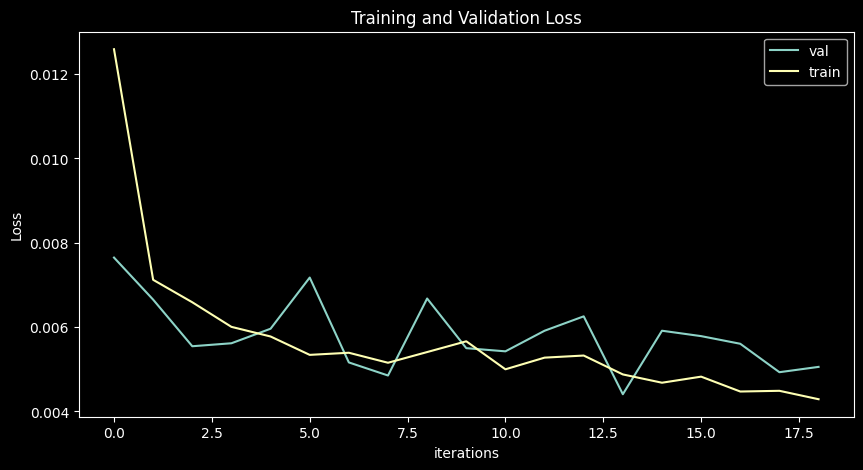

In [12]:
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(val_losses, label="val")
plt.plot(train_losses, label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

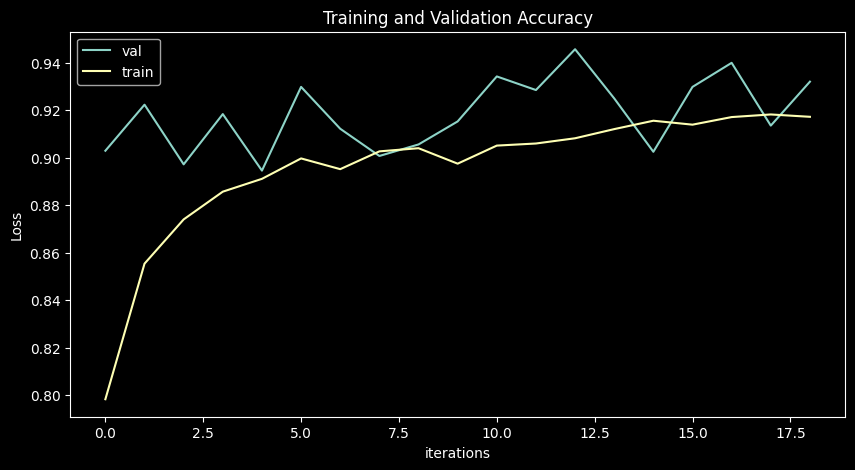

In [13]:
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy")
plt.plot(v_correct_set, label="val")
plt.plot(t_correct_set, label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [14]:
# Viewing the sample of images and to check whether its loading properly
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=8)
dataiter = iter(test_dataloader)

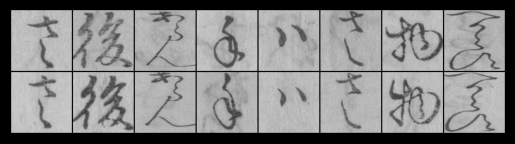

[[0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]]


In [15]:
example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]), 0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [21]:
images_1, images_2, targets = example_batch[0], example_batch[1], example_batch[2]
images_1, images_2, targets = (
    images_1.to(device),
    images_2.to(device),
    targets.to(device),
)
output1, output2 = model(images_1, images_2)
euclidean_distance = F.pairwise_distance(output1, output2)
pred = torch.where(
    euclidean_distance > 1.5, 1, 0
)  # get the index of the max log-probability

In [22]:
euclidean_distance

tensor([0.4766, 4.5098, 0.7105, 2.6653, 0.1283, 0.3250, 2.7667, 0.8344],
       device='cuda:0', grad_fn=<NormBackward1>)

In [23]:
pred

tensor([0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseNetwork().to(device)
model.load_state_dict(torch.load("../siamese/content/model_contrastive.pth"))
model.eval()

SiameseNetwork(
  (resnet): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [10]:
transform = transforms.Compose([transforms.Resize((105, 105)), transforms.ToTensor()])


def transformation(transform, image1_path):
    img = Image.open(image1_path)
    img = img.convert("L")

    # Apply image transformations
    img = transform(img)
    return img


img1 = transformation(transform, "../dataset/1/6135_001_126_0.jpg").to(device)
img2 = transformation(transform, "../dataset/1/18290_001_23_0.jpg").to(device)

o1, o2 = model(img1.unsqueeze(0), img2.unsqueeze(0))
euclidean_distance = F.pairwise_distance(o1, o2)
euclidean_distance

tensor([1.3512], device='cuda:0', grad_fn=<NormBackward1>)

In [24]:
img1 = transformation(transform, "../dataset/1/4612_001_11_0.jpg").to(device)
img2 = transformation(transform, "../dataset/1/29655_001_6_0.jpg").to(device)

o1, o2 = model(img1.unsqueeze(0), img2.unsqueeze(0))
euclidean_distance = F.pairwise_distance(o1, o2)
euclidean_distance

tensor([2.1177], device='cuda:0', grad_fn=<NormBackward1>)

In [25]:
img1 = transformation(transform, "../dataset/1/462_001_101_1.jpg").to(device)
img2 = transformation(transform, "../dataset/1/10640_001_145_0.jpg").to(device)

o1, o2 = model(img1.unsqueeze(0), img2.unsqueeze(0))
euclidean_distance = F.pairwise_distance(o1, o2)
euclidean_distance

tensor([1.3048], device='cuda:0', grad_fn=<NormBackward1>)

In [26]:
img1 = transformation(transform, "../dataset/1/160_001_100_0.jpg").to(device)
img2 = transformation(transform, "../dataset/1/28161_001_63_1.jpg").to(device)

o1, o2 = model(img1.unsqueeze(0), img2.unsqueeze(0))
euclidean_distance = F.pairwise_distance(o1, o2)
euclidean_distance

tensor([1.2850], device='cuda:0', grad_fn=<NormBackward1>)

In [28]:
img1 = transformation(transform, "../dataset/2/1990_001_108_1.jpg").to(device)
img2 = transformation(transform, "../dataset/2/266_001_100_1.jpg").to(device)

o1, o2 = model(img1.unsqueeze(0), img2.unsqueeze(0))
euclidean_distance = F.pairwise_distance(o1, o2)
euclidean_distance

tensor([4.5903], device='cuda:0', grad_fn=<NormBackward1>)

In [29]:
img1 = transformation(transform, "../dataset/1/19090_001_26_1.jpg").to(device)
img2 = transformation(transform, "../dataset/1/26135_001_55_1.jpg").to(device)

o1, o2 = model(img1.unsqueeze(0), img2.unsqueeze(0))
euclidean_distance = F.pairwise_distance(o1, o2)
euclidean_distance

tensor([1.3071], device='cuda:0', grad_fn=<NormBackward1>)

In [35]:
img1 = transformation(
    transform,
    "/fs9/yuxiao/nii_project/dataset/char_block_2/けるに/けるに_0/1/2857_001_111_1.jpg",
).to(device)
img2 = transformation(
    transform,
    "/fs9/yuxiao/nii_project/dataset/char_block_2/けるに/けるに_0/1/29194_001_68_0.jpg",
).to(device)

o1, o2 = model(img1.unsqueeze(0), img2.unsqueeze(0))
euclidean_distance = F.pairwise_distance(o1, o2)
euclidean_distance

tensor([0.9307], device='cuda:0', grad_fn=<NormBackward1>)